In [5]:

import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from bertopic import BERTopic
import string
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
from collections import Counter
import re
from ast import literal_eval
from sentence_transformers import SentenceTransformer
from umap import UMAP
import dataframe_image as dfi

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alicjadorobis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alicjadorobis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [21]:

# loading the data into a dataframe
df = pd.read_csv('../label/100_random_labelled.csv')
display(df)

,created_at_fuzzy,state_likely_tweeted_from,text,source,display_text_width,lang,favorite_count,retweet_count,is_quote,followers_count,friends_count,listed_count,statuses_count,favourites_count,cleaned_text,Toxicity,Fact assessment
0,2020-07-24T06:47:07Z,Kansas,@WhiteHouse @realDonaldTrump Since trump cance...,Twitter Web App,279,en,2,0,False,25,23,0,24,15,Since trump cancelled his convention in Jack...,8,'true'
1,2020-07-23T16:53:44Z,Washington,@drchethansathya 9 year old died in Florida fr...,Twitter for iPhone,189,en,0,0,False,21,168,0,3809,6043,9 year old died in Florida from COVID this we...,8,True
2,2020-07-23T13:10:22Z,Ohio,If trump decides he won’t leave the White Hous...,Twitter for iPhone,268,en,0,0,False,68,97,3,757,664,If trump decides he won’t leave the White Hous...,9,'No verdict'
3,2020-07-22T02:03:52Z,Ohio,"Ao now we have ""the Trump virus"" and the ""Skan...",Twitter Web App,52,en,0,0,True,2995,3073,1,8741,7807,"Ao now we have ""the Trump virus"" and the ""Skan...",8,False
4,2020-07-24T17:21:52Z,Minnesota,@AustinOnSocial That two seconds I spend tryin...,Twitter for iPhone,124,en,0,0,False,99,402,2,9648,4129,That two seconds I spend trying to ace this q...,8,'no verdict'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2020-07-24T00:29:17Z,Ohio,@realDonaldTrump This is just another example ...,Twitter for iPhone,283,en,0,0,False,2,21,0,452,8,This is just another example of why Trump the...,9,'no verdict'
96,2020-07-24T09:20:27Z,New York,"@DavidCornDC In the trump orbit, nothing is un...",Twitter Web App,44,en,0,0,False,849,965,0,11858,75381,"In the trump orbit, nothing is unimaginable.",3,'no verdict'
97,2020-07-24T17:05:36Z,Texas,@NurseMagsy @mmpadellan I'm disappointed but n...,Twitter for Android,237,en,0,0,False,15,66,0,25,165,I'm disappointed but not surprised by Melani...,7,'no verdict'
98,2020-07-23T15:32:02Z,North Carolina,@sarahcpr @ProjectLincoln Who is the interview...,Twitter for iPhone,263,en,1,0,False,930,2119,9,24284,165397,Who is the interviewer &amp; why do they kee...,7,False


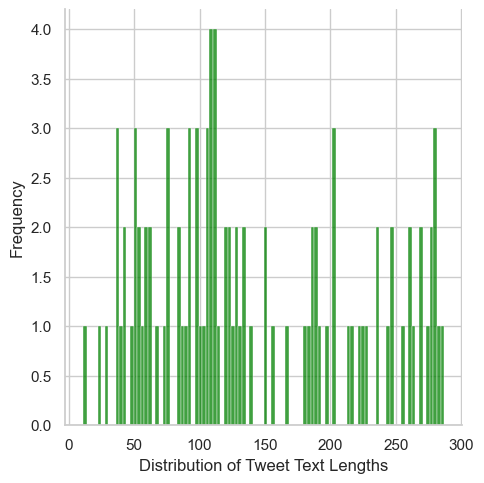

In [11]:
# creating a new column containing the length of each headline text that is larger than 0
non_empty_lengths = df[(df['cleaned_text'].notnull()) & (df['display_text_width'] > 0)]['display_text_width']
# visualising the length distribution 

sns.set(rc={'figure.figsize':(14,11)})
sns.set(style="whitegrid")
sns.displot(non_empty_lengths, kde=False, color='green', bins=100)


plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Distribution of Tweet Text Lengths', fontsize=12)
plt.grid(True)


plt.show()

## Pre-processing the text

In [22]:
#removing line spacing and 'at' symbols
df['cleaned_text'] = df['cleaned_text'].replace('\n',' ', regex=True)
df['cleaned_text'] = df['cleaned_text'].replace('\xa0',' ', regex=True)


In [19]:
'''
# removing all emojis
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
                      
    return re.sub(emoj, '', data)


df['cleaned_text'] = df['cleaned_text'].apply(remove_emojis)
'''

'\n# removing all emojis\ndef remove_emojis(data):\n    emoj = re.compile("["\n        u"😀-🙏"  # emoticons\n        u"🌀-🗿"  # symbols & pictographs\n        u"🚀-\U0001f6ff"  # transport & map symbols\n        u"\U0001f1e0-🇿"  # flags (iOS)\n        u"─-⯯"  # chinese char\n        u"✂-➰"\n        u"Ⓜ-🉑"\n        u"🤦-🤷"\n        u"𐀀-\U0010ffff"\n        u"♀-♂" \n        u"☀-⭕"\n        u"\u200d"\n        u"⏏"\n        u"⏩"\n        u"⌚"\n        u"️"  # dingbats\n        u"〰"\n                      "]+", re.UNICODE)\n                      \n    return re.sub(emoj, \'\', data)\n\n\ndf[\'cleaned_text\'] = df[\'cleaned_text\'].apply(remove_emojis)\n'

In [24]:


print(df['cleaned_text'].head(10))


0      Since trump cancelled his convention in Jack...
1     9 year old died in Florida from COVID this we...
2    If trump decides he won’t leave the White Hous...
3    Ao now we have "the Trump virus" and the "Skan...
4     That two seconds I spend trying to ace this q...
5     Poor fact checking. According to you own sour...
6       Goya bean can claps back at Ivanka Trump  via 
7    ⬇️🔥⬇️ Add sabotage to the corruption, grifting...
8    Declassified Documents Show FBI Used ‘Defensiv...
9      This is video of an America trying to get ou...
Name: cleaned_text, dtype: object


In [25]:
'''
#removing numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)
df['cleaned_text'] = df['cleaned_text'].apply(remove_numbers)
'''

"\n#removing numbers\ndef remove_numbers(text):\n    return re.sub(r'\\d+', '', text)\ndf['cleaned_text'] = df['cleaned_text'].apply(remove_numbers)\n"

In [31]:
def remove_floats(text):
    if isinstance(text, float):
        return ''
    else:
        return text

# Apply remove_floats function to 'cleaned_text' column
try:
    df['cleaned_text'] = df['cleaned_text'].apply(remove_floats)
    print(df['cleaned_text'])
except Exception as e:
    print("An error occurred:", e)


0       Since trump cancelled his convention in Jack...
1      9 year old died in Florida from COVID this we...
2     If trump decides he won’t leave the White Hous...
3     Ao now we have "the Trump virus" and the "Skan...
4      That two seconds I spend trying to ace this q...
                            ...                        
95     This is just another example of why Trump the...
96         In the trump orbit, nothing is unimaginable.
97      I'm disappointed but not surprised by Melani...
98      Who is the interviewer &amp; why do they kee...
99      1] That's what I was alluding to before. Pro...
Name: cleaned_text, Length: 100, dtype: object


In [27]:
'''
#removing punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))


df['cleaned_text'] = df['cleaned_text'].apply(remove_punctuation)
'''


TypeError: 'str' object is not callable

In [126]:
# manually replacing synonyms and words
'''
df['review_text_english'] = df['review_text_english'].str.replace(r'\b(?:bicycle|bikes)\b', 'bike', case=False, regex=True)

df['review_text_english'] = df['review_text_english'].str.replace('places', 'place', case=False)

df['review_text_english'] = df['review_text_english'].str.replace('parkeerplaats', 'parking', case=False)

df['review_text_english'] = df['review_text_english'].str.replace('easily', 'easy', case=False)

df['review_text_english'] = df['review_text_english'].str.replace('authentica', 'authentic', case=False)
df['review_text_english'] = df['review_text_english'].str.replace('genial', 'great', case=False)
df['review_text_english'] = df['review_text_english'].str.replace('pŕ', 'pr', case=False)
df['review_text_english'] = df['review_text_english'].str.replace('combinatie', 'combination', case=False)
'''

1. case-normalization


In [32]:
text_list = df['cleaned_text'].to_list()

#case - normalisation
def case_normalization(text):
    return text.lower()
normalized_text_list = [case_normalization(word) for word in text_list]

print(text_list)


['  Since trump cancelled his convention in Jacksonville "due to health concerns", let\'s see his hypocrite followers say how wonderful he is to care about them and their health, while they\'ve been bitching about stuff being closed and cancelled and Corona being a hoax all this time.', ' 9 year old died in Florida from COVID this week. I know you don’t give a shit because it’s not your kid, but my kid won’t be attending school, no matter what Trump and his dumbass cult say.', 'If trump decides he won’t leave the White House leave him and Melanie there. If she doesn’t kill him let him wander around and mutter to himself about how perfect he is. We can set Biden and a legitimate, thoughtful government up elsewhere. Let’s put Barr in with him.', 'Ao now we have "the Trump virus" and the "Skank flu" ', ' That two seconds I spend trying to ace this quiz each time tho...   They should put that shit into Trump’s Walter Reed test.', ' Poor fact checking. According to you own sources. In Janua

## Visualisation

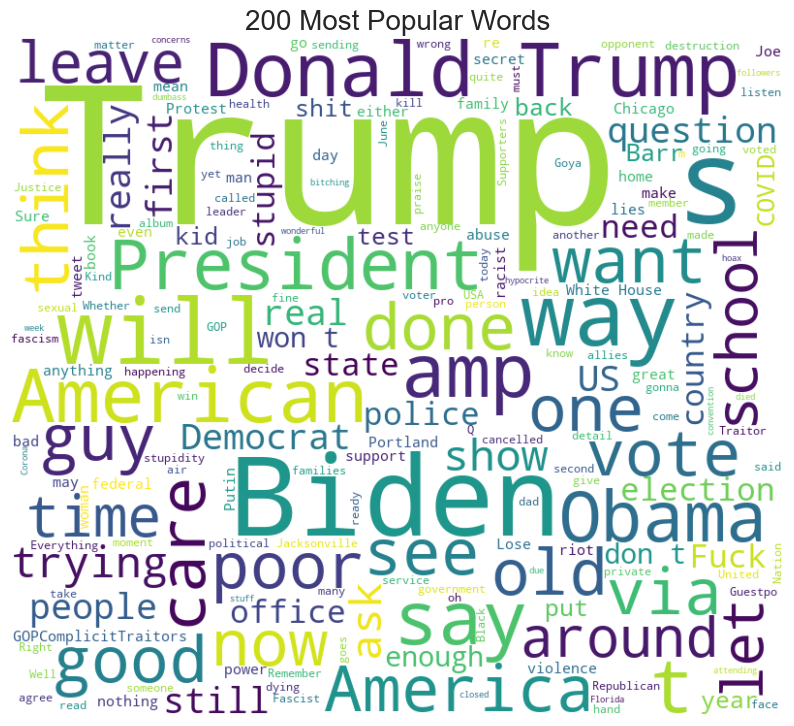

In [33]:
# words visualisation with a wordcloud
concatenated_text = ' '.join(text_list)
# generating
wordcloud = WordCloud(width=800, height=700, max_words=200, background_color='white').generate(concatenated_text)

# plotting the WordCloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('200 Most Popular Words', size= 20)
plt.show()

## Further pre-processing

2. tokenization

In [40]:

def tokenization(text):
    return text.split()
    
tokenized_text_list = [tokenization(word) for word in normalized_text_list]

print(tokenized_text_list)

[['watied', 'minutes', 'with', 'a', 'guy', 'who', 'did', 'not', 'know', 'how', 'to', 'work', 'the', 'cash', 'register', 'before', 'the', 'repairman', 'showed', 'up', 'just', 'to', 'discover', 'they', 'did', 'not', 'repair', 'my', 'flat', 'tyre', 'of', 'the', 'bike', 'i', 'brought', 'in', 'the', 'day', 'before', 'lousy', 'customer', 'service', 'new', 'level', 'of', 'not', 'giving', 'a', 'f'], ['i', 'had', 'a', 'flat', 'tire', 'and', 'they', 'refused', 'to', 'fix', 'it', 'because', 'it', 'was', 'electric', 'bike', 'the', 'back', 'row', 'had', 'nothing', 'to', 'do', 'with', 'the', 'electric', 'part', 'since', 'ive', 'only', 'made', 'it', 'electric', 'by', 'changing', 'the', 'front', 'tire', 'myself', 'i', 'had', 'to', 'walk', 'an', 'hour', 'to', 'find', 'another', 'shop', 'after', 'this', 'dont', 'go', 'here', 'if', 'you', 'have', 'electric', 'bike'], ['these', 'guys', 'were', 'super', 'sweet', 'to', 'me', 'fixed', 'my', 'bike', 'way', 'faster', 'than', 'anticipated', 'and', 'cheap', 'and

3. stopwords removal 

In [41]:

custom_stopwords = ['€']

def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english')).union(set(custom_stopwords or []))  # adding the custom stopwords and english
    return [token for token in tokens if token not in stop_words]

tokens = [remove_stopwords(word) for word in tokenized_text_list]
print(tokens)

[['watied', 'minutes', 'guy', 'know', 'work', 'cash', 'register', 'repairman', 'showed', 'discover', 'repair', 'flat', 'tyre', 'bike', 'brought', 'lousy', 'customer', 'service', 'new', 'level', 'giving', 'f'], ['flat', 'tire', 'refused', 'fix', 'electric', 'bike', 'back', 'row', 'nothing', 'electric', 'part', 'since', 'ive', 'made', 'electric', 'changing', 'front', 'tire', 'walk', 'hour', 'find', 'another', 'shop', 'dont', 'electric', 'bike'], ['guys', 'super', 'sweet', 'fixed', 'bike', 'way', 'faster', 'anticipated', 'cheap', 'speak', 'good', 'english', 'whole', 'thing', 'cost', 'euros', 'new', 'tube', 'including', 'service', 'really', 'recommend'], ['place', 'used', 'good', 'another', 'level', 'dont', 'care', 'care', 'speed', 'repairs', 'call', 'youtext', 'bike', 'ready', 'issues', 'repair', 'instead', 'nothing', 'act', 'surprised', 'show', 'ask', 'takes', 'long', 'left', 'bike', 'repair', 'thursday', 'friday', 'told', 'sorry', 'monday', 'monday', 'shop', 'course', 'message', 'bike',

In [42]:
# transforming into a string to create a model
tokens = [str(token) for token in tokens]
print(tokens)
tokens = [string.strip("'") for string in tokens if string.strip("[]").strip("'")]

["['watied', 'minutes', 'guy', 'know', 'work', 'cash', 'register', 'repairman', 'showed', 'discover', 'repair', 'flat', 'tyre', 'bike', 'brought', 'lousy', 'customer', 'service', 'new', 'level', 'giving', 'f']", "['flat', 'tire', 'refused', 'fix', 'electric', 'bike', 'back', 'row', 'nothing', 'electric', 'part', 'since', 'ive', 'made', 'electric', 'changing', 'front', 'tire', 'walk', 'hour', 'find', 'another', 'shop', 'dont', 'electric', 'bike']", "['guys', 'super', 'sweet', 'fixed', 'bike', 'way', 'faster', 'anticipated', 'cheap', 'speak', 'good', 'english', 'whole', 'thing', 'cost', 'euros', 'new', 'tube', 'including', 'service', 'really', 'recommend']", "['place', 'used', 'good', 'another', 'level', 'dont', 'care', 'care', 'speed', 'repairs', 'call', 'youtext', 'bike', 'ready', 'issues', 'repair', 'instead', 'nothing', 'act', 'surprised', 'show', 'ask', 'takes', 'long', 'left', 'bike', 'repair', 'thursday', 'friday', 'told', 'sorry', 'monday', 'monday', 'shop', 'course', 'message', 

5. stemming and lemmatization

In [43]:

# initialising stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# stemming
stemmed_words = [stemmer.stem(token) for token in tokens]

# lemmatization
lemmatized_words = [lemmatizer.lemmatize(token) for token in tokens]


print("Stemmed Tokens:", stemmed_words)
print("Lemmatized Tokens:", lemmatized_words)
tokens = lemmatized_words

Stemmed Tokens: ["['watied', 'minutes', 'guy', 'know', 'work', 'cash', 'register', 'repairman', 'showed', 'discover', 'repair', 'flat', 'tyre', 'bike', 'brought', 'lousy', 'customer', 'service', 'new', 'level', 'giving', 'f']", "['flat', 'tire', 'refused', 'fix', 'electric', 'bike', 'back', 'row', 'nothing', 'electric', 'part', 'since', 'ive', 'made', 'electric', 'changing', 'front', 'tire', 'walk', 'hour', 'find', 'another', 'shop', 'dont', 'electric', 'bike']", "['guys', 'super', 'sweet', 'fixed', 'bike', 'way', 'faster', 'anticipated', 'cheap', 'speak', 'good', 'english', 'whole', 'thing', 'cost', 'euros', 'new', 'tube', 'including', 'service', 'really', 'recommend']", "['place', 'used', 'good', 'another', 'level', 'dont', 'care', 'care', 'speed', 'repairs', 'call', 'youtext', 'bike', 'ready', 'issues', 'repair', 'instead', 'nothing', 'act', 'surprised', 'show', 'ask', 'takes', 'long', 'left', 'bike', 'repair', 'thursday', 'friday', 'told', 'sorry', 'monday', 'monday', 'shop', 'cour

# Analysis

1. Bag of words 

In [44]:
def bag_of_words(tokens):
    return Counter(tokens)

bag_of_words(tokens)

Counter({"['good']": 10,
         "['great']": 5,
         "['always', 'place']": 5,
         "['nice']": 4,
         "['top']": 4,
         "['perfect']": 4,
         "['bringing', 'car', 'back', 'exactly', 'spot', 'picked', 'forward', 'euro', 'fine', '‘parking', 'spot', 'electric', 'vehicles’', 'customer', 'support', 'completely', 'rude', 'lost', 'loyal', 'customer', 'never', 'use']": 4,
         "['poorer', 'rental', 'experience', 'ever', 'car', 'didn’t', 'start', 'twice', 'top', 'customer', 'service', 'miserable', 'app', 'deleted', 'never', 'use']": 4,
         "['way', 'trip', 'sense', 'rented', 'car', 'near', 'amsterdamse', 'bos', 'ended', 'trip', 'haarlem', 'received', 'sms', 'message', 'return', 'car', 'back', 'specific', 'zone', 'pay', 'fine', 'well', 'business', 'model', 'sucks', 'app', 'completing', 'oneway', 'trip', 'see', 'confirmation', 'joırney', 'completed', 'knew', 'beginning', 'even', 'download', 'app', 'place', 'way', 'trip', 'possible', 'competitors', 'use', 'going'

# Modelling

In [82]:
# preparing embeddings
sentence_model = SentenceTransformer("paraphrase-MiniLM-L3-v2")
embeddings = sentence_model.encode(tokens, show_progress_bar=False)

# training BERTopic
model = BERTopic(verbose=True, embedding_model='paraphrase-MiniLM-L3-v2', min_topic_size=16, nr_topics=11)
review_topics, _ = model.fit_transform(tokens)

# running the visualization with the original embeddings
model.visualize_documents(tokens, embeddings=embeddings)

# reducing dimensionality of embeddings
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)



Batches: 100%|██████████| 81/81 [00:17<00:00,  4.66it/s]
2024-01-15 21:16:04,008 - BERTopic - Transformed documents to Embeddings
2024-01-15 21:16:10,512 - BERTopic - Reduced dimensionality
2024-01-15 21:16:10,590 - BERTopic - Clustered reduced embeddings
2024-01-15 21:16:10,727 - BERTopic - Reduced number of topics from 13 to 11


In [143]:
from sklearn.metrics.pairwise import cosine_similarity

# get topic vectors
topic_vectors = model.transform(tokens)

# compute cosine similarity matrix
cosine_sim_matrix = cosine_similarity(topic_vectors)

# Display the similarity matrix
print("Cosine Similarity Matrix:")
print(cosine_sim_matrix)

Batches:   0%|          | 0/81 [00:00<?, ?it/s]

Batches: 100%|██████████| 81/81 [00:29<00:00,  2.75it/s]
2024-01-15 22:48:04,274 - BERTopic - Reduced dimensionality
2024-01-15 22:48:04,410 - BERTopic - Predicted clusters


Cosine Similarity Matrix:
[[1.         0.31241541]
 [0.31241541 1.        ]]


In [83]:
model.visualize_documents(tokens, reduced_embeddings=reduced_embeddings)

Topic Extraction and Representation

In [100]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

frequency = model.get_topic_info()
print("Number of topics: {}".format( len(frequency)))
display(frequency)
dfi.export(frequency, 'dataframe_topics.png')

Number of topics: 11


,Topic,Count,Name,Representation,Representative_Docs
0,-1,323,-1_beautiful_nice_place_good,"[beautiful, nice, place, good, ideal, top, eas...","[['good', 'place', 'park'], ['nice', 'place', ..."
1,0,1870,0_parking_bike_car_transport,"[parking, bike, car, transport, public, tram, ...","[['great', 'parking', 'easy', 'tram'], ['easy'..."
2,1,82,1_great_good_nice_excellent,"[great, good, nice, excellent, pretty, well, e...","[['great', 'p', 'r'], ['great'], ['nice', 'goo..."
3,2,75,2_station_busy_south_nice,"[station, busy, south, nice, stations, beautif...","[['train', 'station', 'busy'], ['good', 'stati..."
4,3,61,3_staff_friendly_service_rude,"[staff, friendly, service, rude, good, helpful...","[['friendly', 'staff'], ['friendly', 'staff'],..."
5,4,47,4_expensive_price_good_nice,"[expensive, price, good, nice, arranged, servi...","[['perfect', 'expensive'], ['expensive'], ['ex..."
6,5,31,5_easy_reach_handy_connection,"[easy, reach, handy, connection, reliable, top...","[['easy', 'reach', 'easy', 'reach'], ['easy', ..."
7,6,30,6_always_ok_place_drama,"[always, ok, place, drama, confusing, spot, bi...","[['always', 'place'], ['always', 'place'], ['a..."
8,7,22,7_spacious_easy_accessible_place,"[spacious, easy, accessible, place, drive, fit...","[['spacious', 'easy', 'accessible'], ['spaciou..."
9,8,18,8_cheap_pack_perfect_super,"[cheap, pack, perfect, super, covered, cheapwa...","[['perfect', 'cheap'], ['cheap'], ['cheap']]"


-1 refers to all outliers and should typically be ignored. Next, let's take a look at the most frequent topic that was generated, topic 0:

In [85]:
model.get_topic(0)

[('parking', 0.043724873189067655),
 ('bike', 0.03330053294285552),
 ('car', 0.030607803826038164),
 ('transport', 0.02778499476638052),
 ('public', 0.027500244275990716),
 ('tram', 0.025534572933147565),
 ('euros', 0.020224215480289368),
 ('bus', 0.02021462272002041),
 ('people', 0.019945552139577622),
 ('garage', 0.019043771068112697)]

In [86]:
model.get_document_info(tokens)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,"['watied', 'minutes', 'guy', 'know', 'work', '...",0,0_parking_bike_car_transport,"[parking, bike, car, transport, public, tram, ...","[['great', 'parking', 'easy', 'tram'], ['easy'...",parking - bike - car - transport - public - tr...,1.000000,False
1,"['flat', 'tire', 'refused', 'fix', 'electric',...",0,0_parking_bike_car_transport,"[parking, bike, car, transport, public, tram, ...","[['great', 'parking', 'easy', 'tram'], ['easy'...",parking - bike - car - transport - public - tr...,1.000000,False
2,"['guys', 'super', 'sweet', 'fixed', 'bike', 'w...",0,0_parking_bike_car_transport,"[parking, bike, car, transport, public, tram, ...","[['great', 'parking', 'easy', 'tram'], ['easy'...",parking - bike - car - transport - public - tr...,1.000000,False
3,"['place', 'used', 'good', 'another', 'level', ...",0,0_parking_bike_car_transport,"[parking, bike, car, transport, public, tram, ...","[['great', 'parking', 'easy', 'tram'], ['easy'...",parking - bike - car - transport - public - tr...,1.000000,False
4,"['place', 'contains', 'bike', 'repairshop', 'n...",0,0_parking_bike_car_transport,"[parking, bike, car, transport, public, tram, ...","[['great', 'parking', 'easy', 'tram'], ['easy'...",parking - bike - car - transport - public - tr...,1.000000,False
...,...,...,...,...,...,...,...,...
2571,"['nice', 'employeesneat', 'storage']",-1,-1_beautiful_nice_place_good,"[beautiful, nice, place, good, ideal, top, eas...","[['good', 'place', 'park'], ['nice', 'place', ...",beautiful - nice - place - good - ideal - top ...,0.000000,False
2572,"['doesnt', 'work']",6,6_always_ok_place_drama,"[always, ok, place, drama, confusing, spot, bi...","[['always', 'place'], ['always', 'place'], ['a...",always - ok - place - drama - confusing - spot...,1.000000,False
2573,"['easy', 'safe', 'bike', 'park', 'free', 'free']",0,0_parking_bike_car_transport,"[parking, bike, car, transport, public, tram, ...","[['great', 'parking', 'easy', 'tram'], ['easy'...",parking - bike - car - transport - public - tr...,0.940366,False
2574,"['location', 'public', 'transport', 'bicycles'...",0,0_parking_bike_car_transport,"[parking, bike, car, transport, public, tram, ...","[['great', 'parking', 'easy', 'tram'], ['easy'...",parking - bike - car - transport - public - tr...,1.000000,False


Top terms and c-TF-IDF scores

In [87]:
a_topic = frequency.iloc[1]["Topic"] # selecting the 1st topic
model.get_topic(a_topic) # showing the words and their c-TF-IDF scores

[('parking', 0.043724873189067655),
 ('bike', 0.03330053294285552),
 ('car', 0.030607803826038164),
 ('transport', 0.02778499476638052),
 ('public', 0.027500244275990716),
 ('tram', 0.025534572933147565),
 ('euros', 0.020224215480289368),
 ('bus', 0.02021462272002041),
 ('people', 0.019945552139577622),
 ('garage', 0.019043771068112697)]

Topic visualisation


In [88]:

model.visualize_barchart(top_n_topics=17, n_words= 10, width = 300, height = 350)

In [75]:
model.visualize_topics()

In [101]:
# Calculate the percentage representation of topics

your_docs = tokens
topic_counts = Counter(review_topics)
total_documents = len(your_docs)
topic_percentages = {topic: count / total_documents * 100 for topic, count in topic_counts.items()}
topic_percentages = {topic: round(count / total_documents * 100, 2) for topic, count in topic_counts.items()}

# Create a DataFrame from the topic percentages
df_topic_percentages = pd.DataFrame(list(topic_percentages.items()), columns=['Topic', 'Percentage of documents in a topic'])
df_topic_percentages = df_topic_percentages.sort_values(by='Topic', ascending=True)
df_topic_percentages['Percentage of documents in a topic'] = df_topic_percentages['Percentage of documents in a topic'].astype(str) + '%'

# Display the DataFrame
display(df_topic_percentages)

dfi.export(df_topic_percentages, 'dataframe_topics%.png')

,Topic,Percentage of documents in a topic
3,-1,12.54%
0,0,72.59%
5,1,3.18%
4,2,2.91%
2,3,2.37%
6,4,1.82%
8,5,1.2%
1,6,1.16%
10,7,0.85%
7,8,0.7%


In [90]:
model.visualize_hierarchy(top_n_topics=30)

In [91]:
similar_topics, similarity = model.find_topics("politics", top_n = 3)
most_similar = similar_topics[0]
print("Most Similar Topic Info: \n{}".format(model.get_topic(most_similar)))
print("Similarity Score: {}".format(similarity[0]))

Most Similar Topic Info: 
[('always', 0.5015271330305474), ('ok', 0.4227863078637988), ('place', 0.41250118217009774), ('drama', 0.2351294643942437), ('confusing', 0.2254878368170022), ('spot', 0.17943554264645534), ('bit', 0.16755369547521282), ('everything', 0.16002908952851355), ('unavailable', 0.15494956708765367), ('winner', 0.15494956708765367)]
Similarity Score: 0.13532403968221576


In [92]:
#saving the model
model.save("bert_best_model_tweets")

# loading the serialised model
my_best_model = BERTopic.load("bert_best_model_tweets")
my_best_model